In [39]:
# Predicting potential alliance shifts in a world war using graph balance theory
# Heron Ziegel
# 915986142

import numpy as np
import pandas as pd
import networkx as nx

In [40]:
# Grab WW1 data to test with
input_data = pd.read_csv('../Data/WW1.csv', index_col=0)
G = nx.Graph(input_data.values)
G.remove_edges_from(nx.selfloop_edges(G))

print(input_data)
print(G)

                UK  France  Russia  Italy  Germany  AustriaHungary
UK               1       2       2      0        0               2
France           2       1       2      0        2               2
Russia           2       2       1      0        1               1
Italy            0       0       0      1        0               0
Germany          0       2       1      0        1               1
AustriaHungary   2       2       1      0        1               1
Graph with 6 nodes and 9 edges


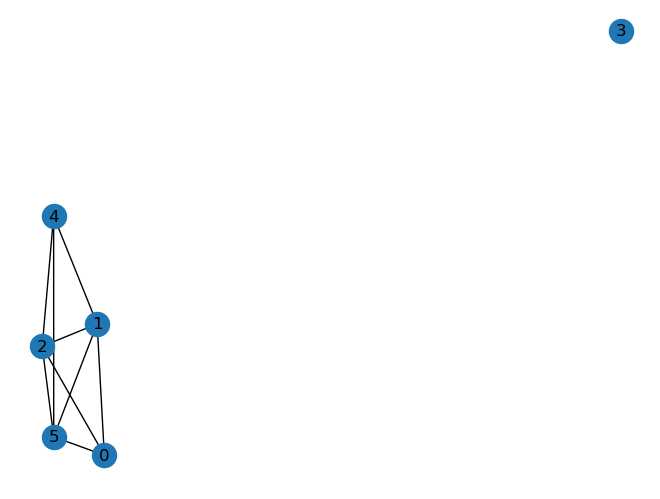

In [54]:
# Visualize initial graph
#my_labels = list(df.columns.values)
#my_labels.pop(0)

nx.draw(G, with_labels=True)